In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from plotnine import *
from plotnine.data import mpg
import matplotlib.pyplot as plt

#Create dataframes from Excel

df = pd.read_excel('oct_2019.xlsx', sheet_name='All Flights') #CHANGE FILE AND SHEET NAMES
df2 = pd.read_excel('regionMapping.xlsx', sheet_name='regionMapping') #CHANGE FILE AND SHEET NAMES
df3 = pd.read_excel('regionMapping2.xlsx', sheet_name='regionMapping') #CHANGE FILE AND SHEET NAMES


#Join dataframes to get rid of international flights
df = df.join(df2.set_index('Station'), on='Org')
df = df.join(df3.set_index('Station'), on='Dst')
df = df.dropna(subset=['Orig Region','Dest Region'])

#THIS MELTS DF
melt = pd.melt(df, id_vars=['Flt','Org','Dst','Eqt','Dptr','Arvl','BLK MINS','MILES','Desk'] 
	,value_vars=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
	,var_name = 'Day'
	,value_name = 'Schd')

#Drop not scheduled flights N/A
melt = melt.dropna(subset=['Schd'])

#Set Year, Month and Date
melt['Month'] =  10
melt['Year'] =  2019
melt['Date'] = pd.to_datetime(melt[['Year', 'Month', 'Day']])

#Make Departure, Arrival, and Release time columns
melt['Dept Time'] = pd.to_datetime(melt['Year'].astype(str) + '/' + melt['Month'].astype(str) + '/' + melt['Day'].astype(str) + ' ' +melt['Dptr'].astype(str),utc=True)
melt['Arr Time'] = pd.to_datetime(melt['Year'].astype(str) + '/' + melt['Month'].astype(str) + '/' + melt['Day'].astype(str) + ' ' +melt['Arvl'].astype(str),utc=True)
melt['Rls Time'] = melt['Dept Time'] + pd.Timedelta(minutes=-90)



In [12]:
#Make Hour Columns for each time
melt['Rls HR'] = melt['Rls Time'].dt.hour
melt['Dept HR'] = melt['Dept Time'].dt.hour
melt['Arr HR'] = melt['Arr Time'].dt.hour

melt['FltID'] = melt['Dept Time'].astype(str) + melt['Flt'].astype(str) + melt['Org'].astype(str) + melt['Dst'].astype(str)

#Print Sample
print(melt.head())
melt['FltID']
# melt.dtypes

#Export melted df to a csv
export_csv = melt.to_csv(r'oct_2019 MELT.csv', header=True) #CHANGE FILE NAME
# export_csv = melt['FltID'].to_csv(r'FltID.csv', header=True) #CHANGE FILE NAME


   Flt  Org  Dst  Eqt      Dptr      Arvl  BLK MINS  MILES Desk Day  ...  \
0   68  PDX  SLC  739  20:13:00  21:58:00       105    630    1   1  ...   
2  367  DEN  LAX  319  18:06:00  20:37:00       151    862    1   1  ...   
3  367  LAX  DEN  319  15:00:00  17:19:00       139    862    1   1  ...   
4  473  LAX  PDX  319  16:05:00  18:31:00       146    834    1   1  ...   
5  473  PDX  LAX  319  19:25:00  21:40:00       135    834    1   1  ...   

  Month  Year       Date                 Dept Time                  Arr Time  \
0    10  2019 2019-10-01 2019-10-01 20:13:00+00:00 2019-10-01 21:58:00+00:00   
2    10  2019 2019-10-01 2019-10-01 18:06:00+00:00 2019-10-01 20:37:00+00:00   
3    10  2019 2019-10-01 2019-10-01 15:00:00+00:00 2019-10-01 17:19:00+00:00   
4    10  2019 2019-10-01 2019-10-01 16:05:00+00:00 2019-10-01 18:31:00+00:00   
5    10  2019 2019-10-01 2019-10-01 19:25:00+00:00 2019-10-01 21:40:00+00:00   

                   Rls Time Rls HR  Dept HR  Arr HR  \
0 2019-

In [13]:
#Set day
daymelt = melt[melt['Day'] == 1]

#Get counts for each hour
Rhour = daymelt.groupby(['Rls HR']).count()[['Flt']]
Dhour = daymelt.groupby(['Dept HR']).count()[['Flt']]
Ahour = daymelt.groupby(['Arr HR']).count()[['Flt']]

#Merge counts into one table
HR1 = pd.merge(Rhour,Dhour,right_index=True, left_index=True,how='outer')
Hours = pd.merge(HR1,Ahour,right_index=True, left_index=True,how='outer')

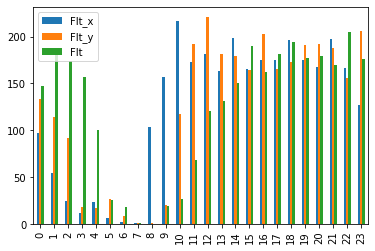

In [14]:
#Plot
# Rplot = Rhour.plot.bar()
# Dplot = Dhour.plot.bar()
# Aplot = Ahour.plot.bar()

Hours.plot.bar()

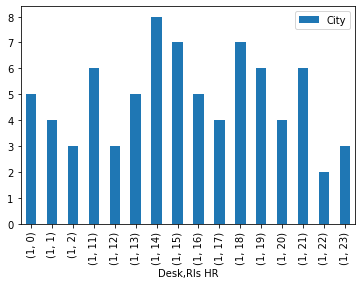

In [138]:
daymelt = melt[melt['Day'] == 1]
deskmelt = daymelt[daymelt['Desk'] == 1]

org_cities = deskmelt.filter(['Org','Desk','Rls HR'])
org_cities = org_cities.filter(['Org','Desk','Rls HR']).rename(columns={"Org": "City"})

dst_cities = deskmelt.filter(['Dst','Desk','Rls HR'])
dst_cities = dst_cities.filter(['Dst','Desk','Rls HR']).rename(columns={"Dst": "City"})

cities = org_cities.append(dst_cities).groupby(['Desk','Rls HR']).nunique()
cities = cities.filter(['City'])

cities.plot.bar(y='City')

# export_csv = cities.to_csv(r'Cities.csv', header=True) #CHANGE FILE NAME